In [1]:
import pandas as pd 
import numpy as np 
import nltk
import re
from nltk.stem import WordNetLemmatizer 
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [2]:
d = pd.read_csv('train.csv',encoding='latin-1',header=None,skiprows=1587000)
d = d.drop([1],axis=1)
d = d.drop([2],axis=1)
d = d.drop([3],axis=1)
d = d.drop([4],axis=1)
d['class'] = d[0]
d['tweet'] = d[5]
d = d.drop([0],axis=1)
d = d.drop([5],axis=1)
d['class'] = np.zeros(13000,dtype=int)+2
e = np.zeros(13000,dtype = int)
e[0] = 24783
for i in range(1,13000):
    e[i] = e[i-1] + 1 
d['index']=e
d = d.set_index('index')

In [3]:
d

,class,tweet
index,,
24783,2,"Celebrating the 482nd bird day of Jakarta, ple..."
24784,2,@shanetechteach I wasn't offended! I was enter...
24785,2,The reason's why I use TweetLater... http://b...
24786,2,"@JimAyson if you can help, we can make it happ..."
24787,2,"@iDazz No cause when I left for work, it look..."
...,...,...
37778,2,Just woke up. Having no school is the best fee...
37779,2,TheWDB.com - Very cool to hear old Walt interv...
37780,2,Are you ready for your MoJo Makeover? Ask me f...


In [4]:
#loading a labeled twitter dataset
# keys: {0:hate_speech,1:offensive_language,2:neither}
df = pd.read_pickle("labeled_data.p")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24783 entries, 0 to 25296
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               24783 non-null  int64 
 1   hate_speech         24783 non-null  int64 
 2   offensive_language  24783 non-null  int64 
 3   neither             24783 non-null  int64 
 4   class               24783 non-null  object
 5   tweet               24783 non-null  object
dtypes: int64(4), object(2)
memory usage: 1.3+ MB


In [5]:
df.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [6]:
# changing the index to continuous integers as the default index is discontinuous, and dropping unnecessary columns
index = []
for j in range(0,24783):
    index.append(j)
df['index']=index
df = df.set_index(df['index'])
df = df.drop(['index'],axis=1)
df = df.drop(['count'],axis=1)
df = df.drop(['hate_speech'],axis=1)
df = df.drop(['offensive_language'],axis=1)
df = df.drop(['neither'],axis=1)

In [7]:
df

,class,tweet
index,,
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,2,"you've gone and broke the wrong heart baby, an..."
24780,1,young buck wanna eat!!.. dat nigguh like I ain...


In [8]:
df = pd.concat([df,d])

In [9]:
df

,class,tweet
index,,
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
37778,2,Just woke up. Having no school is the best fee...
37779,2,TheWDB.com - Very cool to hear old Walt interv...
37780,2,Are you ready for your MoJo Makeover? Ask me f...


In [10]:
# Storing the number of tweets in each category to visualize the distribution
key=['hate','offensive','neither']
g = []
for h in range(0,3):
    g.append([key[h],df['tweet'][df['class']==h].count()])
category_count=pd.DataFrame(g)

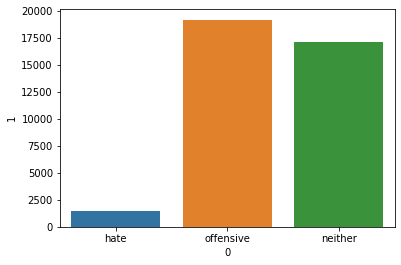

In [11]:
sns.barplot(x=0,y=1,data=category_count)

In [12]:
def remove_excalmation_at_beginning(str):
    # Removes exclamation marks at the beginning of the tweet
    exclamation = '!!*'
    e=re.match(exclamation,str)
    if(e):
        return re.split(exclamation,str)[1]
    else:
        return str
def rt_remove(str):
    # Some tweets start with 'RT', this function removes the string "RT" at the beginning
    rt = '^ RT '
    e=re.match(rt,str)
    if(e):
        return re.split(rt,str)[1]
    else:
        return str
def word_lemmatize(str):
    # Returns lemmatized words
    lemmatizer=WordNetLemmatizer()
    return lemmatizer.lemmatize(str)
def remove_nametag(str):
    # Replaces the tagged name in a tweet with '', which will be later removed
    name_tag = '@[\w\-(:)]+'
    return re.sub(name_tag,'',str)
def remove_space_at_beginning(str):
    # Removes space at the beginning of a tweet
    return str.lstrip()
def remove_url(str):
    # Replaces the URL in the tweets with '
    url = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|''[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return re.sub(url,'',str)
def tokenizer(str): 
    # Returns a list containing words from the input string
    return str.split()
def lower_case(str):
    # Returns a string with all characters as lower case
    return str.lower()
def hashtag_remover(str):
    # Removes # from tweets 
    return str.split('#')[1]
def special_char_remove(str):
    # Removes the strings which start with &#(which are found abundant in the tweets)
    return re.sub('&#[(0-9)(a-z)]+','',str)
def remove_numbers(str):
    return re.sub('[0-9]+','',str)
def remove_num_char(str):
    return re.sub('[0-9][a-z]+','',str)
def remove_underscore(str):
    return re.sub('_([a-z]+)|(_)+','',str)

In [13]:
for i in range(0,df['tweet'].count()):
    df['tweet'].loc[i] = remove_excalmation_at_beginning(df['tweet'].loc[i])
    df['tweet'].loc[i] = rt_remove(df['tweet'].loc[i])
    df['tweet'].loc[i] = remove_space_at_beginning(df['tweet'].loc[i])
    df['tweet'].loc[i] = df['tweet'].loc[i].lstrip()
    df['tweet'].loc[i] = remove_nametag(df['tweet'].loc[i])
    df['tweet'].loc[i] = remove_url(df['tweet'].loc[i])
    df['tweet'].loc[i] = tokenizer(df['tweet'].loc[i])   

In [14]:
for i in range(0,df['tweet'].count()):
    for j in range(0,len(df['tweet'].loc[i])):
        df['tweet'].loc[i][j] = lower_case(df['tweet'].loc[i][j])
        df['tweet'].loc[i][j] = word_lemmatize(df['tweet'].loc[i][j]) 
        df['tweet'].loc[i][j] = special_char_remove(df['tweet'].loc[i][j])
        df['tweet'].loc[i][j] = remove_numbers(df['tweet'].loc[i][j])
        df['tweet'].loc[i][j] = remove_num_char(df['tweet'].loc[i][j])
        df['tweet'].loc[i][j] = remove_underscore(df['tweet'].loc[i][j])
        if re.match('#[(a-z)(0-9)]+',df['tweet'].loc[i][j]):
            df['tweet'].loc[i][j] = hashtag_remover(df['tweet'].loc[i][j])    
    while( '"' in df['tweet'].loc[i]):
        df['tweet'].loc[i].remove('"')  

In [15]:
# removing the stop words from the tweets
stop_words = set(stopwords.words('english'))
for i in range(0,df['tweet'].count()):
    for w in df['tweet'].loc[i]:
        if w in stop_words:
            df['tweet'].loc[i].remove(w)

In [16]:
df['tweet']

index
0        [woman, shouldn't, complain, cleaning, your, h...
1        [boy, dat, cold...tyga, dwn, bad, cuffin, dat,...
2                                                   [dawg]
3                                     [look, like, tranny]
4        [shit, hear, me, might, true, might, faker, th...
                               ...                        
37778    [woke, up., no, school, the, best, feeling, ever]
37779    [thewdb.com, -, cool, hear, old, walt, intervi...
37780    [you, ready, your, mojo, makeover?, ask, for, ...
37781    [happy, th, birthday, my, boo, alll, time!!!, ...
37782                              [happy, charitytuesday]
Name: tweet, Length: 37783, dtype: object

In [17]:
# concatenating all the words to obtain the tweets, which are cleaned from unnecessary strings
for i in range(0,df['tweet'].count()):
    t = ''
    for j in range(0,len(df['tweet'].loc[i])):
        t = t + df['tweet'].loc[i][j] + ' '
    df['tweet'].loc[i] = t 

In [20]:
df

,class,tweet
index,,
0,2,woman shouldn't complain cleaning your house. ...
1,1,boy dat cold...tyga dwn bad cuffin dat hoe the...
2,1,dawg
3,1,look like tranny
4,1,shit hear me might true might faker the bitch ...
...,...,...
37778,2,woke up. no school the best feeling ever
37779,2,thewdb.com - cool hear old walt interviews! â...
37780,2,you ready your mojo makeover? ask for detail


In [19]:
#saving the preprocessed data to a new csv file
df.to_csv('labeled_data.csv',index = True)